# ARIMAX on client + exogenous context info

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')

from datetime import date, timedelta, datetime
import numpy as np
import statsmodels.api as sm

In [2]:
from colour import Color

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.style.use('dark_background')

orange = Color("orange")

color_objs = list(orange.range_to(Color("slateblue"), 14))
colors = [col.hex for col in color_objs]
len(colors)

14

### Read datasets

In [3]:
basedate = date(2020, 1, 1)

deltify = lambda x: (x - basedate).days

In [4]:
npzfile0 = np.load('./sber_work_files/final/clients_w_gr_names.npz', allow_pickle=True)

client_df = npzfile0['client_df']
group_names = npzfile0['group_names']

In [5]:
num_gr = 0
print(f"Now working with group: {group_names[num_gr]}")

cli_data = client_df[:,num_gr,:].T
print(f"Shape of ndarray: {cli_data.shape}")

cli_df = pd.DataFrame(data=cli_data[0:,0:], \
                     index=[basedate + timedelta(i) for i in range(cli_data.shape[0])], \
                     columns=[f"c{i}" for i in range(cli_data.shape[1])])

cli_df = cli_df.sum(axis=1)
cli_df = cli_df.asfreq('d')
print(len(cli_df))

cli_df.head()

Now working with group: food
Shape of ndarray: (274, 7287)
274


2020-01-01    3288475.76
2020-01-02    5031752.65
2020-01-03    5538428.97
2020-01-04    5874405.23
2020-01-05    5834887.85
Freq: D, dtype: float64

In [6]:
cli_df.tail()

2020-09-26    7152844.21
2020-09-27    6021555.37
2020-09-28    4968958.56
2020-09-29    5074798.98
2020-09-30    5074798.98
Freq: D, dtype: float64

In [7]:
#cli_df_seasonal = cli_df.apply(lambda x: \
#                               sm.tsa.seasonal_decompose(x, model='additive').trend)
#
#res = sm.tsa.seasonal_decompose(cli_df['c0'].dropna())
#res.plot()

In [8]:
start_test = date(2020, 9, 20)

In [9]:
cli_test = cli_df[cli_df.index.date >= start_test].copy()
cli_train = cli_df[cli_df.index.date < start_test].copy()

### Set up news

In [10]:
npzfile1 = np.load('./sber_work_files/final/news4work.npz', allow_pickle=True)

month_ticks = npzfile1['month_ticks']
month_names = npzfile1['month_names']
fin_top_ts = npzfile1['fin_top_ts']
fin_top_names = npzfile1['fin_top_names']
sorted_topic_names_dict = npzfile1['sorted_topic_names_dict']

In [11]:
news_data = fin_top_ts.T
print(news_data.shape)

news_df = pd.DataFrame(data=news_data[0:,0:], \
                     index=[basedate + timedelta(i) for i in range(news_data.shape[0])], \
                     columns=[f"n{i}" for i in range(news_data.shape[1])])

news_df = news_df.fillna(0).asfreq('d')
news_df.head()

(274, 13)


,n0,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,n11,n12
2020-01-01,0.0,1.000000,29.000000,22.000000,13.000000,15.000000,15.000000,16.000000,12.000000,0.0,21.000000,13.000000,0.0
2020-01-02,0.0,1.616368,33.332759,21.785414,12.895061,15.888366,12.498857,14.649069,11.654498,0.0,22.710833,14.958091,0.0
2020-01-03,0.0,2.122519,36.935551,21.594737,12.777482,16.671087,10.402857,13.557972,11.471783,0.0,24.184722,16.787294,0.0
2020-01-04,0.0,2.518451,39.808375,21.427971,12.647264,17.348161,8.712000,12.726710,11.451854,0.0,25.421667,18.487610,0.0
2020-01-05,0.0,2.804165,41.951232,21.285114,12.504407,17.919590,7.426285,12.155281,11.594711,0.0,26.421667,20.059039,0.0


In [12]:
news_test = news_df[news_df.index.date >= start_test].copy()
news_train = news_df[news_df.index.date < start_test].copy()

# ARIMAX

In [13]:
arimax = sm.tsa.statespace.SARIMAX(cli_train, \
                                order=(7,1,7), \
                                seasonal_order=(0,0,0,0), \
                                exog = news_train, \
                                freq='D', \
                                enforce_stationarity=False, \
                                enforce_invertibility=False).fit(disp=False)
pred = arimax.predict(start_test, date(2020, 9, 30), exog=news_test)[1:]
print(pred)

2020-09-21    4.826620e+06
2020-09-22    4.958647e+06
2020-09-23    5.257838e+06
2020-09-24    6.221480e+06
2020-09-25    7.609159e+06
2020-09-26    8.113983e+06
2020-09-27    7.699923e+06
2020-09-28    7.760614e+06
2020-09-29    8.537191e+06
2020-09-30    9.471732e+06
Freq: D, Name: predicted_mean, dtype: float64


/home/dormant/.local/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


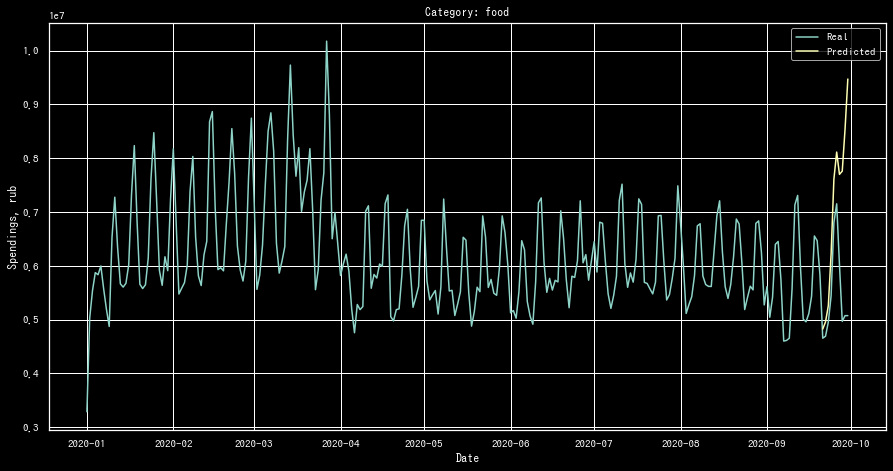

In [20]:
plt.plot(cli_df)
plt.plot(pred)
plt.title(f"Category: {group_names[num_gr]}")
plt.ylabel("Spendings, rub")
plt.xlabel("Date")
plt.legend(["Real", "Predicted"])